## Runing the DEEP AA on the MNIST dataset


In [33]:
import sys, torch, scprep
sys.path.append('../')
import warnings; warnings.filterwarnings('ignore')
from AAnet_torch import *
from torch import optim
import torchvision; from torchvision import datasets, transforms
import numpy as np
import matplotlib; import matplotlib.pyplot as plt
from AAnet_torch import models, utils, data, plot
import os
from scipy.spatial.distance import squareform, pdist
import umap

## Load MNIST data

In [18]:
# 1. Load and Preprocess MNIST (The "Binary" way)
print("Loading MNIST...")
transform = transforms.Compose([transforms.ToTensor(), transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_all = mnist.data.numpy()
data_all = data_all / 255
data_all = (data_all * 2) - 1 # norm
labels = mnist.targets.numpy()

print("MNIST Loaded. Data shape:", data_all.shape)

Loading MNIST...
MNIST Loaded. Data shape: (60000, 28, 28)


In [19]:

# Pick single digit
digit = 4

# Select data for the specified digit
idx_digit = mnist.targets.numpy() == digit

# Create dataset for the selected digit
data_digit = data_all[idx_digit,]

# Reshape data to 2D array (samples x features)
data_digit = np.reshape(data_digit, (data_digit.shape[0], -1))

# Print shape of the digit-specific dataset
print(data_digit.shape)



(5842, 784)


## AAnet

In [20]:
N_ARCHETYPES = 3
N_RUNS = 5
N_EPOCHS = 10      
N_PROTOTYPES = 10     

SAVE_DIR = 'results/MNIST_5runs'
os.makedirs(SAVE_DIR, exist_ok=True)

data_loader = torch.utils.data.DataLoader(data_digit, batch_size=256, shuffle=True, num_workers=4)

# Added a transposoition to ensure final shape
X = torch.tensor(data_digit, dtype=torch.float64).transpose(0, 1)

# Warm-start model with graph-based extrema for improved results
extrema = torch.Tensor(utils.get_laplacian_extrema(data_digit, n_extrema=N_ARCHETYPES))
extrema = torch.Tensor(data_digit[extrema.numpy().astype(int)])



In [21]:
device = torch.device('cpu')
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES, 
                             input_shape=data_digit.shape[1],
                             device=device, diffusion_extrema=extrema)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Run AAnet

In [50]:
from tqdm import trange
import torch
import numpy as np
import os

S_list = []
C_list = []
L_list = []  

for run in range(N_RUNS):
    print(f"Run {run+1}/{N_RUNS}")

    # Train for N_EPOCHS with progress bar
    for epoch in trange(1, N_EPOCHS + 1, desc=f"Training Run {run+1}", leave=False):
        loss, r_loss, a_loss = utils.train_epoch(model, data_loader, optimizer, epoch=epoch, gamma_extrema=1.0)
    
    # Encode final embeddings
    archetypal_embedding = model.encode(torch.Tensor(data_digit)).detach().numpy()  # shape: (N_samples, k)
    print("Archetypal_embedding shape:", archetypal_embedding.shape)
    
    # Convert to barycentric coordinates
    barycentric_embedding = model.euclidean_to_barycentric(torch.Tensor(archetypal_embedding)).detach().numpy()
    
    # S: (archetypes × samples)
    S_T = barycentric_embedding.T          # shape: (archetypes, samples)
    C = S_T.T                             # shape: (samples, archetypes)
    
    # Save run results
    S_list.append(S_T)
    C_list.append(C)
    
    print(f"Run {run+1} - S shape: {S_T.shape}, C shape: {C.shape}, X shape: {data_digit.shape}")  

    # Optional: save per run
    np.savez(os.path.join(SAVE_DIR, f'run{run+1}_results.npz'), S=S_T, C=C, X=data_digit)

# Save all runs together
torch.save({'S_list': S_list, 'C_list': C_list, 'X': data_digit}, os.path.join(SAVE_DIR, 'mnist_aanet_aa_results.pth'))

# Save the model state dict of the last run
torch.save(model.state_dict(), os.path.join(SAVE_DIR, 'mnist_aanet_model_last_run.pth'))

print(f"✅ Saved all {N_RUNS} runs results.")


Run 1/5


Archetypal_embedding shape: (5842, 2)
Run 1 - S shape: (3, 5842), C shape: (5842, 3), X shape: (5842, 784)
Run 2/5


KeyboardInterrupt: 

## Visualize the Results

In [9]:
# Open the saved results to verify
results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/AAnet/example_notebooks/results/MNIST_5runs/mnist_aanet_aa_results.pth', weights_only=False)
print("Saved Results Keys:", results.keys())
print("Number of Runs Saved:", len(results['C_list']))

# Print shapes if the first run to verify
print("Shape of C in first run:", results['C_list'][0].shape)
print("Shape of S in first run:", results['S_list'][0].shape)
print('Shape of X in first run:', results['X'].shape)

Saved Results Keys: dict_keys(['S_list', 'C_list', 'X'])
Number of Runs Saved: 5
Shape of C in first run: (5842, 3)
Shape of S in first run: (3, 5842)
Shape of X in first run: (5842, 784)


# Metric Formulas

In [27]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 10e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0), np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY > 0)
    MI = np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))
    return MI

def calcNMI(z1, z2):
    NMI = (2 * calcMI(z1, z2)) / (calcMI(z1, z1) + calcMI(z2, z2))
    return NMI

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    # Greedy matching
    i = []
    j = []
    v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) + D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

In [ ]:
from itertools import combinations

# Calculate metrics over the runs
C_matrices = [to_numpy(C) for C in results['C_list']]
print("C_matrices length:", len(C_matrices))
print("C_matrices[0] shape:", C_matrices[0].shape)
S_matrices = [to_numpy(S) for S in results['S_list']]
print("S_matrices length:", len(S_matrices))
print("S_matrices[0] shape:", S_matrices[0].shape)

X_centered, mSST = preprocess(to_numpy(X))

X_raw = to_numpy(X)

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix

# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_matrices, C_matrices, X_raw, N_RUNS)

print("---")
print("Deep AANET AA 5-run stability:")
print("---")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


C_matrices length: 5
C_matrices[0] shape: (5842, 3)
S_matrices length: 5
S_matrices[0] shape: (3, 5842)
---
Deep AANET AA 5-run stability:
---
Mean NMI: 0.9834277934862339
Mean Archetype Consistency: 0.9966966122039029
Mean ISI: 0.49752697975207993


---

# Archetypal Analysis

In [ ]:
# Select archetypes to visualize from the loaded results
C_aanet = results['C_list'][0]
S_aanet = results['S_list'][0]

print("C_aanet shape:", C_aanet.shape)
print("S_aanet shape:", S_aanet.shape)

C_aanet shape: (5842, 3)
S_aanet shape: (3, 5842)


### Visualizing the Archetypes

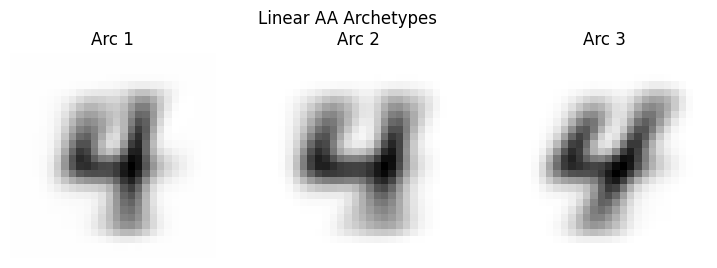

In [51]:
def plot_archetypes(C, img_shape=(28, 28), title="Archetypes"):
    C = C.copy()
    k = C.shape[1]

    fig, axes = plt.subplots(1, k, figsize=(3*k, 3))
    for i in range(k):
        axes[i].imshow(C[:, i].reshape(img_shape), cmap="gray_r")
        axes[i].set_title(f"Arc {i+1}")
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()

# compute pixel-space archetypes
C_recon = X_raw @ S_matrices[0].T 

plot_archetypes(C_recon, title="Linear AA Archetypes")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


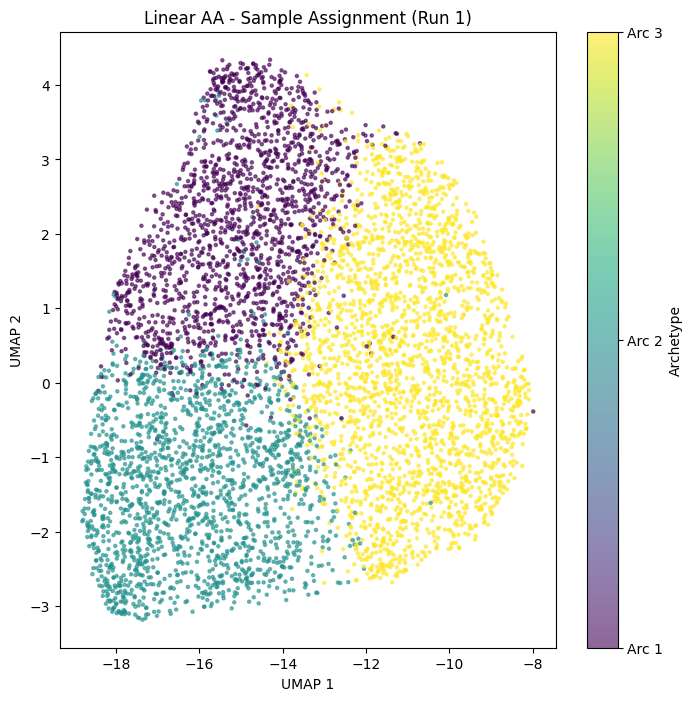

In [ ]:

def plot_umap_assignment(X, S, title="Sample Assignment", s=5, alpha=0.6, cmap='viridis'):

    # Convert S to numpy if tensor
    S = to_numpy(S)
    X = to_numpy(X)

    # Step 1: compute dominant archetype for each sample
    dominant_arc = np.argmax(S, axis=0)  # shape: (N_samples,)

    # Step 2: reduce X to 2D using UMAP
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
    X_embedded = reducer.fit_transform(X)  # shape: (N_samples, 2)

    # Step 3: scatter plot colored by dominant archetype
    n_archetypes = S.shape[0]
    plt.figure(figsize=(8,8))
    scatter = plt.scatter(
        X_embedded[:,0],
        X_embedded[:,1],
        c=dominant_arc,
        cmap=cmap,
        s=s,
        alpha=alpha
    )
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")

    # Colorbar
    cbar = plt.colorbar(scatter, ticks=np.arange(n_archetypes))
    cbar.set_label("Archetype")
    cbar.set_ticklabels([f"Arc {i+1}" for i in range(n_archetypes)])

    plt.show()

# Linear AA: S_matrices[0] shape (k × N_samples)
plot_umap_assignment(X_samples, S_matrices[0], title="Linear AA - Sample Assignment (Run 1)")


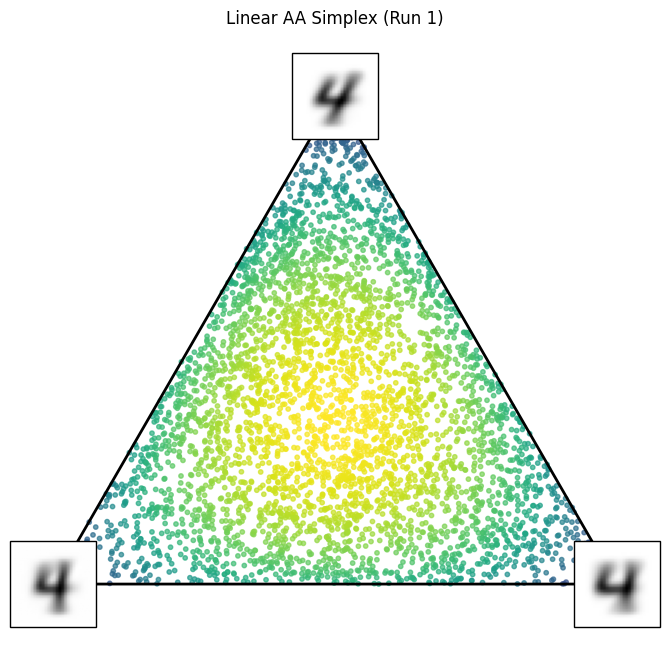

In [ ]:
def plot_simplex(S, C=None, title="Simplex Plot", s=10, cmap='viridis', show_archetypes=True):
    S = np.array(S)
    k, N = S.shape
    if k != 3:
        raise ValueError("Simplex plot only works for k=3 archetypes")
    
    # Barycentric coordinates -> 2D triangle coordinates
    vertices = np.array([[0,0], [1,0], [0.5, np.sqrt(3)/2]])
    X_simplex = S.T @ vertices  # shape: (N_samples, 2)

    # Compute mixing strength (entropy)
    from scipy.stats import entropy
    mix_strength = np.array([entropy(S[:,i]) for i in range(N)])
    mix_strength /= np.log(3)  # normalize between 0 and 1

    # Plot samples
    plt.figure(figsize=(8,8))
    plt.scatter(X_simplex[:,0], X_simplex[:,1], c=mix_strength, cmap=cmap, s=s, alpha=0.7)
    
    # Draw triangle edges
    triangle = plt.Polygon(vertices, fill=False, edgecolor='black', linewidth=2)
    plt.gca().add_patch(triangle)
    
    # Plot archetypes at corners if requested
    if show_archetypes and C is not None:
        from matplotlib.offsetbox import OffsetImage, AnnotationBbox
        for i in range(3):
            img = C[:, i].reshape(28,28)  # adjust if different feature dims
            im_box = OffsetImage(img, zoom=2.0, cmap='gray_r')
            ab = AnnotationBbox(im_box, vertices[i], frameon=True, pad=0.3)
            plt.gca().add_artist(ab)

    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.show()

# Linear AA
plot_simplex(S_matrices[0], C=C_recon, title="Linear AA Simplex (Run 1)")


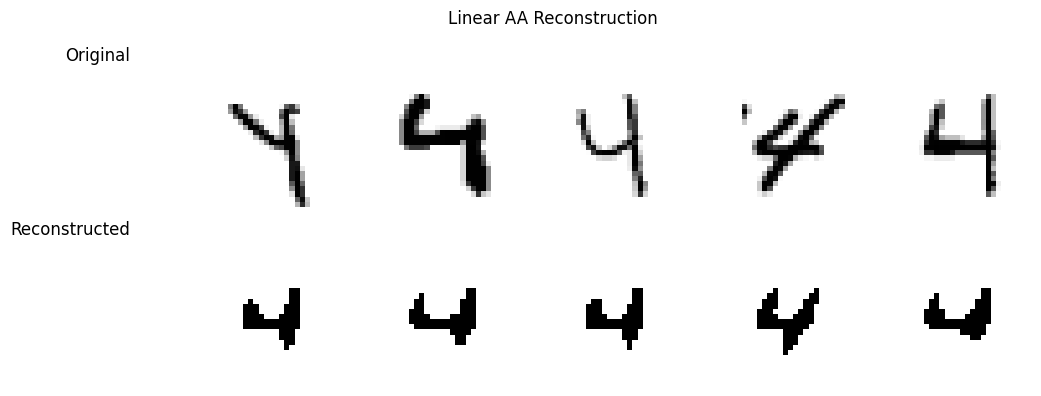

In [ ]:
def plot_reconstruction_flat(X_orig, X_recon, n_samples=5, img_shape=(28,28), title="Reconstruction"):
    """
    Visualize random original samples and their reconstructions.

    X_orig: (samples, features)
    X_recon: (samples, features)
    """
    indices = np.random.choice(X_orig.shape[0], n_samples, replace=False)
    fig, axes = plt.subplots(2, n_samples, figsize=(2*n_samples, 4))

    for i, idx in enumerate(indices):
        # Original
        axes[0, i].imshow(X_orig[idx].reshape(img_shape), cmap='gray_r')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Original", x=-0.5, ha='right')

        # Reconstructed
        rec = np.clip(X_recon[idx].reshape(img_shape), X_orig.min(), X_orig.max())
        axes[1, i].imshow(rec, cmap='gray_r')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("Reconstructed", x=-0.5, ha='right')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Make sure X_raw is (samples, features)
X_samples = X_raw.T  # shape: (5842, 784)
C_recon = X_samples.T @ S_matrices[0].T  # (784, k)

# Reconstruct samples
X_rec = (C_recon @ S_matrices[0]).T 

plot_reconstruction_flat(X_samples, X_rec, n_samples=5, title="Linear AA Reconstruction")

### DAQUI PARA BAIXO É EXTRA STUFF FORM THE TUTORIAL

### Visualize latent space

In [ ]:
archetypal_embedding = model.encode(torch.Tensor(data_digit))
vertices_embedding = model.get_n_simplex(n=3)
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()

<Axes: >

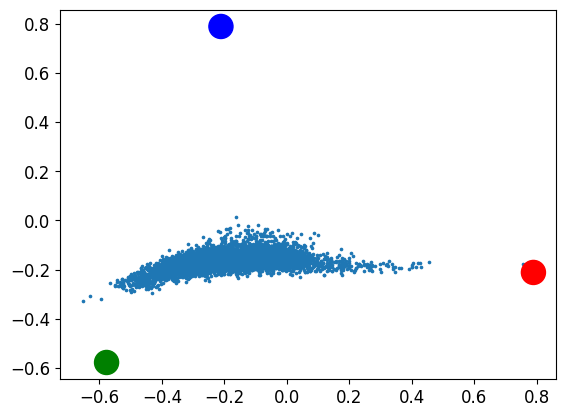

In [ ]:
fig, ax = plt.subplots()
scprep.plot.scatter2d(archetypal_embedding.detach().numpy(), ax=ax)
scprep.plot.scatter2d(vertices_embedding.detach().numpy(), ax=ax, c=['red', 'blue', 'green'], s=300)

### Visualize average of 20 images nearest each archetype

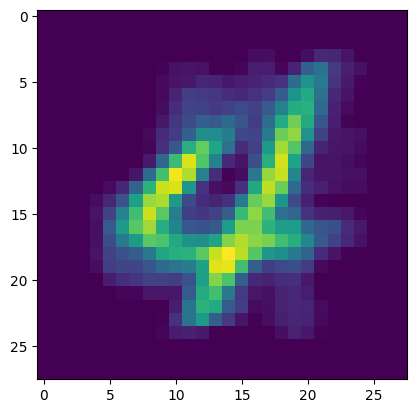

In [38]:
images_close_to_red_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 0])[::-1][:20]
images_close_to_red_archetype = data_digit[images_close_to_red_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_red_archetype.mean(axis=0))

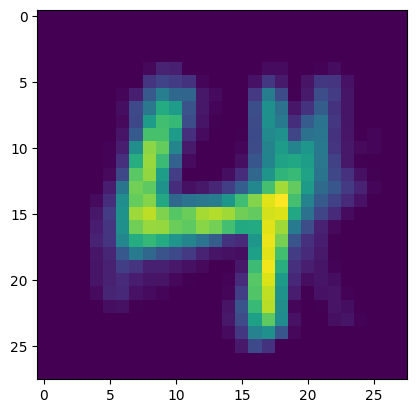

In [42]:
images_close_to_blue_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 1])[::-1][:20]
images_close_to_blue_archetype = data_digit[images_close_to_blue_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_blue_archetype.mean(axis=0))

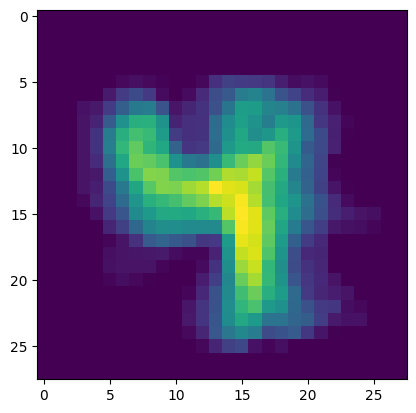

In [41]:
images_close_to_green_archetype_idx = np.argsort(barycentric_archetypal_embedding[:, 2])[::-1][:20]
images_close_to_green_archetype = data_digit[images_close_to_green_archetype_idx].reshape(20, 28, 28)
plt.imshow(images_close_to_green_archetype.mean(axis=0))